In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel, ExpSineSquared, DotProduct, Matern, RationalQuadratic
from sklearn.ensemble import RandomForestClassifier

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Degree in Data Science and Engineering, group 96
## Double Degree in Data Science and Engineering
## & Engineering in Telecommunication Technologies, group 196
## Machine Learning 2
### Fall 2024

&nbsp;
&nbsp;
&nbsp;
# Lab 5. Gaussian Processes for classification

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**, **David Martínez Rubio**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Loading data

In this assignment you are working with a benchmark data set of hand-written digits. Each observation is formed by 64 features: the gray scale of the corresponding pixel in the $8 \times 8$ image of the digit. The true target matching each observation is the integer that corresponds to the number in the image.

Execute the following cell to load the data and prepare the different training and test sets.

Loaded 1797 observations with 64 features


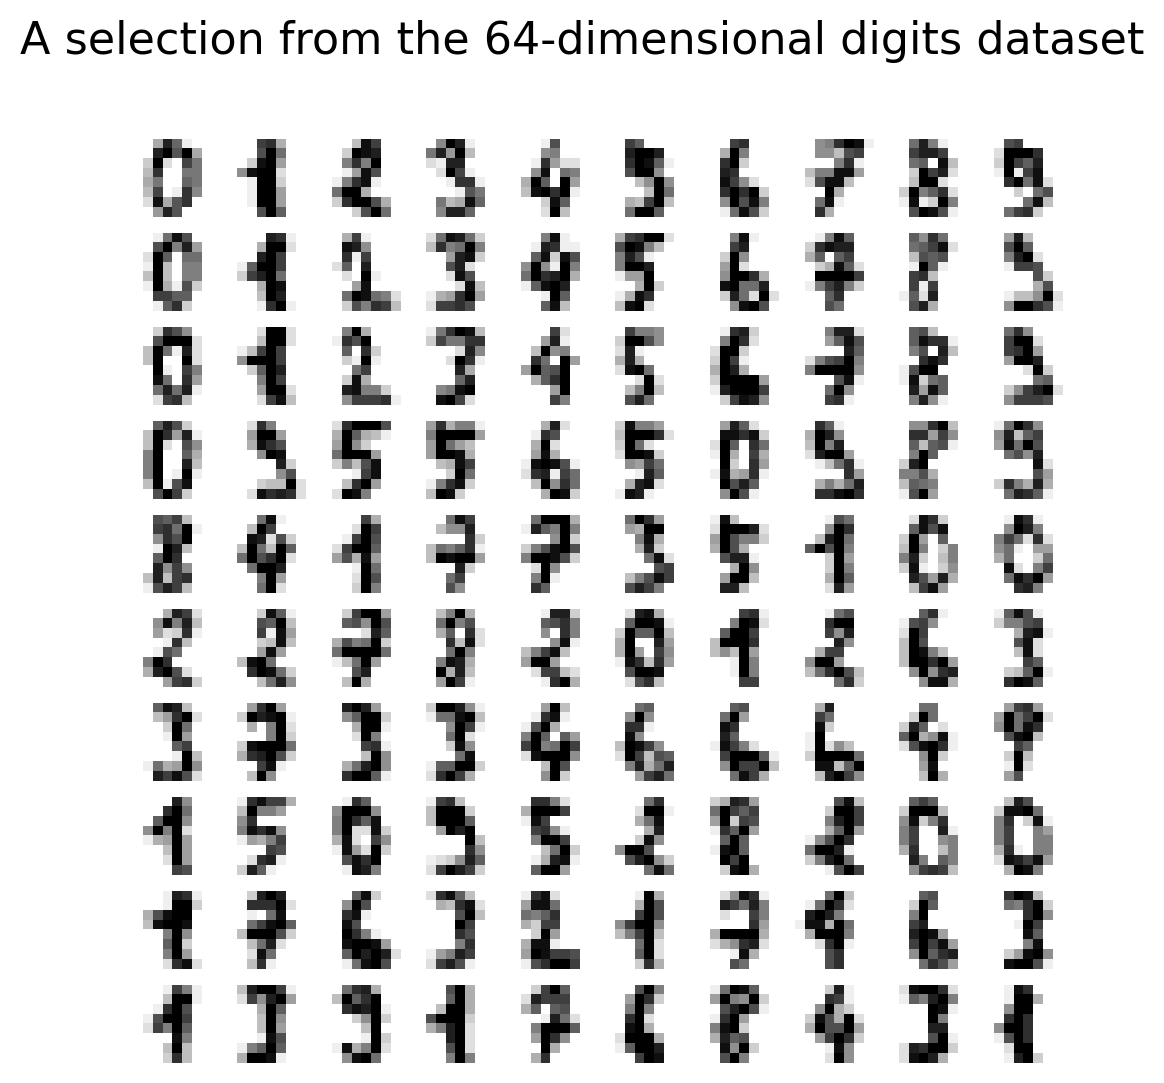

In [5]:


digits = load_digits(n_class=10)
X, y = digits.data, digits.target
n_samples, n_features = X.shape

print("Loaded {0:d} observations with {1:d} features".format(n_samples, n_features))


# plot a few examples
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

#split into training and test sets
Xtrain_all, Xtest_all, Ytrain_all, Ytest_all =  train_test_split(X, y, train_size=0.5,random_state=42)

# Definition of binary classification problems

Function `binary_classification_problem` in the next cell returns the training and testing data set corresponding to the binary classification task defined by taking the observations of integer `cp` as instances of the positive class and the observations of integer `cn` as instances of the negative class.

Learn how it works in order to use it through the assignment.



In [6]:
def binary_classification_problem(cp=2, cn=3):
  p_train = Ytrain_all == cp
  p_test = Ytest_all == cp
  n_train = Ytrain_all == cn
  n_test = Ytest_all == cn

  Xtrain_binary = np.vstack((Xtrain_all[p_train,:],
                      Xtrain_all[n_train,:]))
  Ytrain_binary = np.hstack((Ytrain_all[p_train],
                      Ytrain_all[n_train]))


  Xtest_binary = np.vstack((Xtest_all[p_test,:],
                            Xtest_all[n_test,:]))
  Ytest_binary = np.hstack((Ytest_all[p_test],
                            Ytest_all[n_test]))
  return Xtrain_binary, Xtest_binary, Ytrain_binary, Ytest_binary



# 1.- Digit 7 vs. digit 9

Obtain the datasets corresponding to the binary classification task involving separating the instances of digit $7$ from those of digit $9$.

In [7]:
"""
Your code
"""
cp = 7  # Positive class (digit 7)
cn = 9  # Negative class (digit 9)
Xtrain_binary, Xtest_binary, Ytrain_binary, Ytest_binary = binary_classification_problem(cp, cn)
rf_classifier = RandomForestClassifier(n_estimators=100, max_leaf_nodes=50, random_state=42)
rf_classifier.fit(Xtrain_binary, Ytrain_binary)

accuracy = rf_classifier.score(Xtest_binary, Ytest_binary)
print("Random Forest Accuracy:", accuracy)

feature_relevance_rf_79 = rf_classifier.feature_importances_
sorted_indices_rf_79 = np.argsort(feature_relevance_rf_79)[::-1]  # Sort in descending order


Random Forest Accuracy: 0.9608938547486033


## 1.1 Preliminar analysis with Random Forests

You are using Random Forests as the benchmark technology that will help you assess the quality achieved by the models based on Gaussian Processes. For this purpose, in the next cell write code that:

- Fit a random forest classifier with 100 trees, `max_leaf_nodes` set to $50$ and `random_state` set to $42$ (why 42? consider reading "The Hitchhiker's Guide to the Galaxy" if you haven't done so yet) with the training data
- Print the classification accuracy of this random forest in the test data.
- Construct a *numpy* array called `feature_relevance_rf_79` with the relevance of each of the 64 features for the classification task (**hint** consider random forest attribute `feature_importances_`).
- Get the indices of the features sorted in decreasing order of relevance in an array called `sorted_indices_rf_79` (**hint** consider *numpy* function `arg_sort`)

In [ ]:
print(sorted_indices_rf_79)

[53 60 61 43 36 44 42 51 18 54 26 35 46 17 27 45 19 25 34 59  6 20  3 10
 62 28 21  9 14 52 22 12 29 11  4 58 33 30 38  2 37 41 49  7  5 13 50 23
 15 63  1 55  8 31 16 24 32 39 40 47 48 56 57  0]


The next cell plots the relevance of the features in decreasing order and its cummulative sum. Notice that the values in `feature_importances_` add up to $1$.

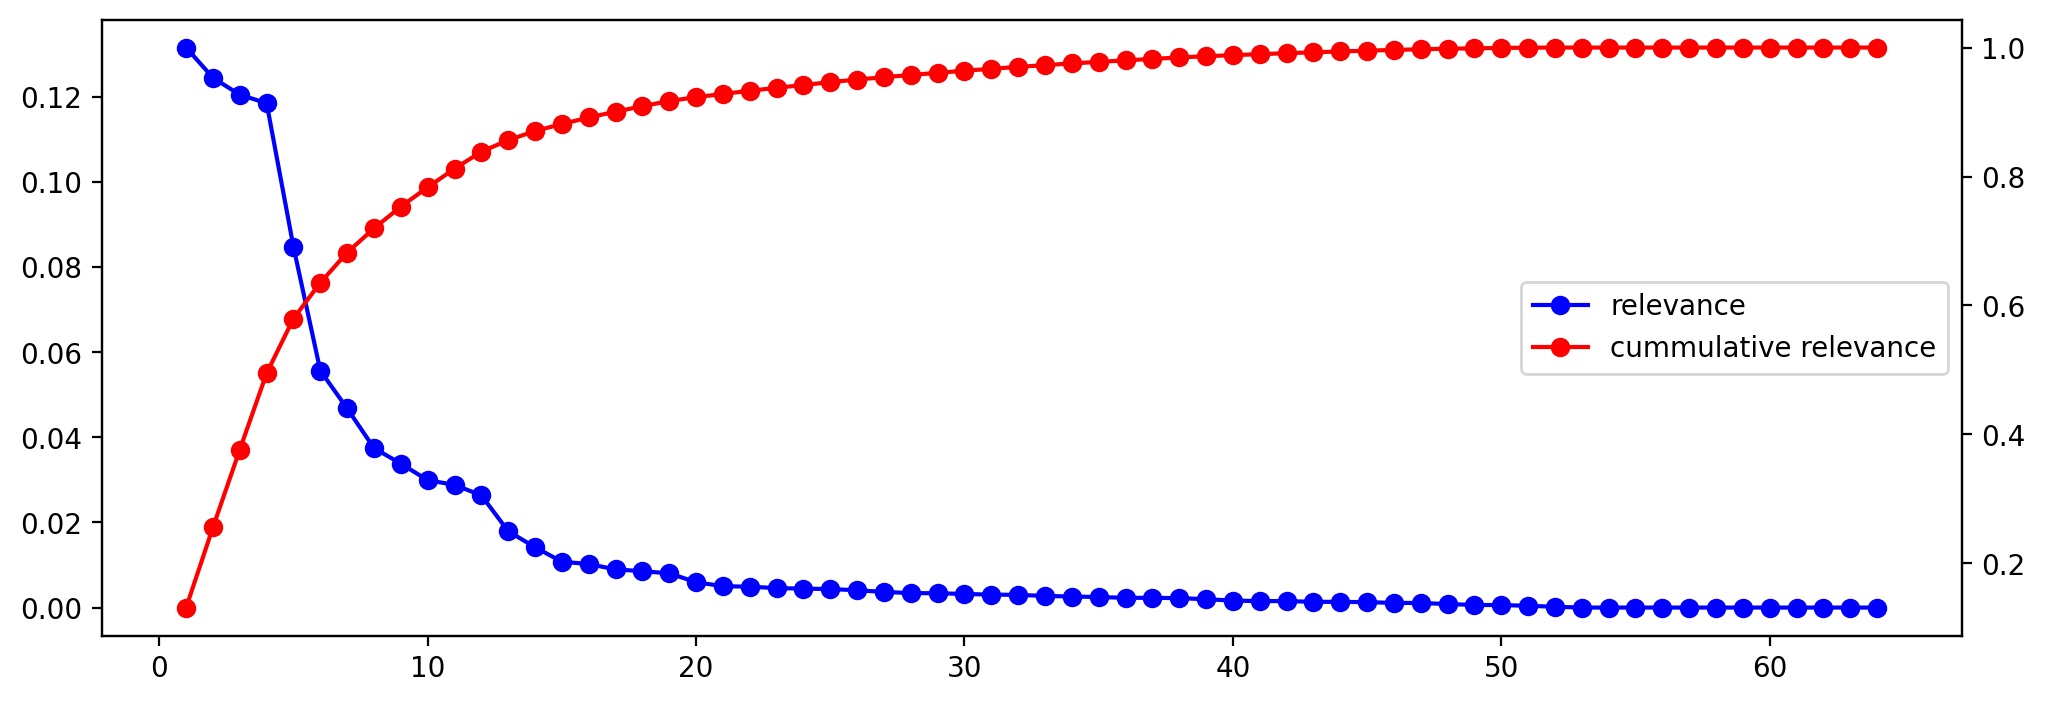

In [ ]:
ff,aa = plt.subplots(1,1,figsize=(12,4))
a1 = aa.plot([cc for cc in range(1,65)],
         feature_relevance_rf_79[sorted_indices_rf_79],
         marker='o',
         label='relevance',
        color = 'blue')
bb = aa.twinx()

b1 = bb.plot([cc for cc in range(1,65)],
         np.cumsum(feature_relevance_rf_79[sorted_indices_rf_79]),
         marker='o',
         label='cummulative relevance',
        color='red')

c = a1+b1
labs = [l.get_label() for l in c]
_=aa.legend(c, labs, loc='center right')

## 1.2 Analysis with Gaussian Processes

For this part of the assignment you are using Gaussian Processes endowed with  ARD (Automatic Relevance Determination) kernels. These kernels are RBF kernels in which each feature can have a different lengthscale.

When you instantiate the kernel you assign an initial value to each lengthscale.
After calling method `fit`, the GP optimizer will also optimize the value of each of the lengthscales between the ranges specified in argument `length_scale_bounds`. **Find out how the final value of the lenghtscale can be related to the relevance of the feature by comparing the impact in the final value of the kernel of features with a large lenghtscale with the impact of features with a small lengthscale.**

In the following cell write code that:
- Instantiates a composite kernel formed by the product of a constant kernel and an ARD kernel with an initial value of $2$ for all the lengthscales and the `length_scale_bounds` set to `(1e-3, 1e10)`
- Instantiate a Gaussian Process with that kernel, `n_restarts_optimizer` set to 5 and `random_state` set to 42.
- Fit the GP with the training data of the '7' vs. 9 problem
- Print the classification accuracy of the GP in the test data.
- Store the final lengthscales of the 64 features in an array called `lengthscales_gp_79` (**hint** explore method `get_params` within attribute `kernel_` in the GP)
- Get the indices of the features sorted in decreasing order of relevancev (remember the relationship between lengthscale anc relevance) in an array called `sorted_indices_gp_79`

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the kernel
# Instead of a single lengthscale for all features, using an array of lengthscales, one for each feature
kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(Xtrain_binary.shape[1]), (1e-3, 1e10))

# Create and train the Gaussian Process classifier
gp_classifier = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=5, random_state=42)
gp_classifier.fit(Xtrain_binary, Ytrain_binary)

# Evaluate accuracy
accuracy = gp_classifier.score(Xtest_binary, Ytest_binary)
print("Gaussian Process Accuracy:", accuracy)

# Get lengthscales
# Since we're using an array of lengthscales, this should now work correctly
lengthscales_gp_79 = gp_classifier.kernel_.k2.get_params()['length_scale']
sorted_indices_gp_79 = np.argsort(lengthscales_gp_79)  # Sort in ascending order (smaller lengthscale = more relevant)

Gaussian Process Accuracy: 0.9664804469273743


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:45

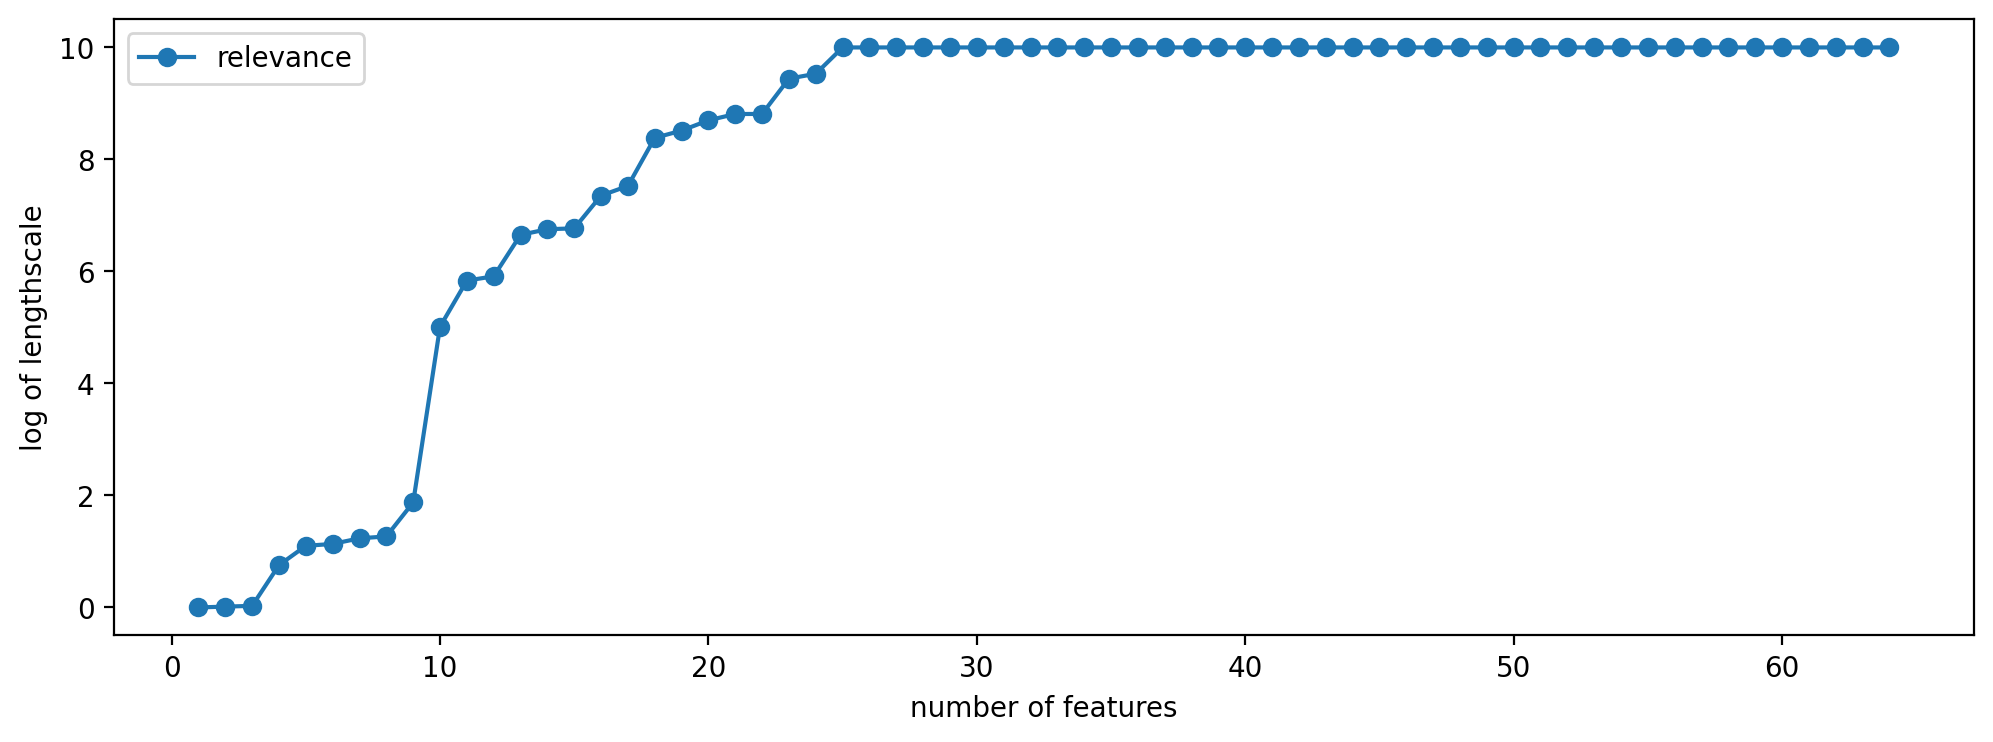

In [ ]:
ff,aa = plt.subplots(1,1,figsize=(12,4))
a1 = aa.plot([cc for cc in range(1,65)],
         np.log10(lengthscales_gp_79[sorted_indices_gp_79]),
         marker='o',
         label='relevance')
aa.set_ylabel('log of lengthscale')
aa.set_xlabel('number of features')
_= aa.legend()

## 1.3 Explanation of outcome

In this cell you will try to get some insights about the differences in performances of both algorithms.
Complete the code in the lines indicated below

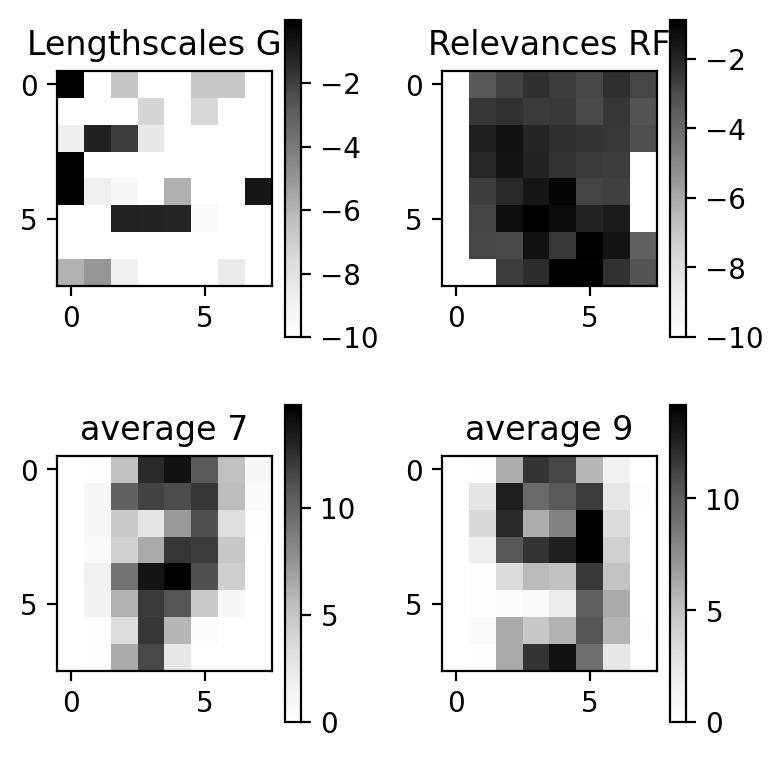

In [ ]:
ff,aa = plt.subplots(2,2, figsize=(4,4))
# The first row plots the relevance of each pixels according to GP (left) and to RF (right)
# The values are scaled between -10 (less relevant) and 0 (more relevant).
# With the color codes black means relevant and white non relevant

log_ls_gp = -np.log10(lengthscales_gp_79)

ax = aa[0][0]
cc = ax.imshow(log_ls_gp.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('Lengthscales GP')

log_fi_rf = -10*np.ones(64)
log_fi_rf[feature_relevance_rf_79>0] = np.log10(feature_relevance_rf_79[feature_relevance_rf_79>0])
ax = aa[0][1]
cc = ax.imshow(log_fi_rf.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('Relevances RF')

# The second row plots show the average observation of each class, in order to get insights about
# how the values of the pixels are distributed in each class. The intuition is that relevant pixels
# should be those that look different depending on the observation being a member of the positive
# or of the negative class.

ax = aa[1][0]
## compute the mean of the observations of in the training set of the positive class
##
## YOUR CODE
##
mean_positive_class = np.mean(Xtrain_binary[Ytrain_binary == cp], axis=0)
cc = ax.imshow(mean_positive_class.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('average {0:d}'.format(cp))

ax = aa[1][1]
## compute the mean of the observations of in the training set of the negative class
##
## YOUR CODE
##
mean_negative_class = np.mean(Xtrain_binary[Ytrain_binary == cn], axis=0)
cc = ax.imshow(mean_negative_class.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('average {0:d}'.format(cn))


ff.tight_layout()

# 2.- Digit 5 vs. digit 6

Now we change to another pair of digits. Obtain the datasets corresponding to the binary classification task involving separating the instances of digit $5$ from those of digit $6$.

In [ ]:
"""
Your code
"""

cp = 5
cn = 6
Xtrain_binary, Xtest_binary, Ytrain_binary, Ytest_binary = binary_classification_problem(cp, cn)


## 2.1 Preliminar analysis with Random Forests

Repeat section 1.1 but with the new datasets.

In [ ]:
"""
Your code
"""
rf_classifier = RandomForestClassifier(n_estimators=100, max_leaf_nodes=50, random_state=42)
rf_classifier.fit(Xtrain_binary, Ytrain_binary)

accuracy = rf_classifier.score(Xtest_binary, Ytest_binary)
print("Random Forest Accuracy:", accuracy)

feature_relevance_rf_56 = rf_classifier.feature_importances_
sorted_indices_rf_56 = np.argsort(feature_relevance_rf_79)[::-1]  # Sort in descending order

Random Forest Accuracy: 0.9898477157360406


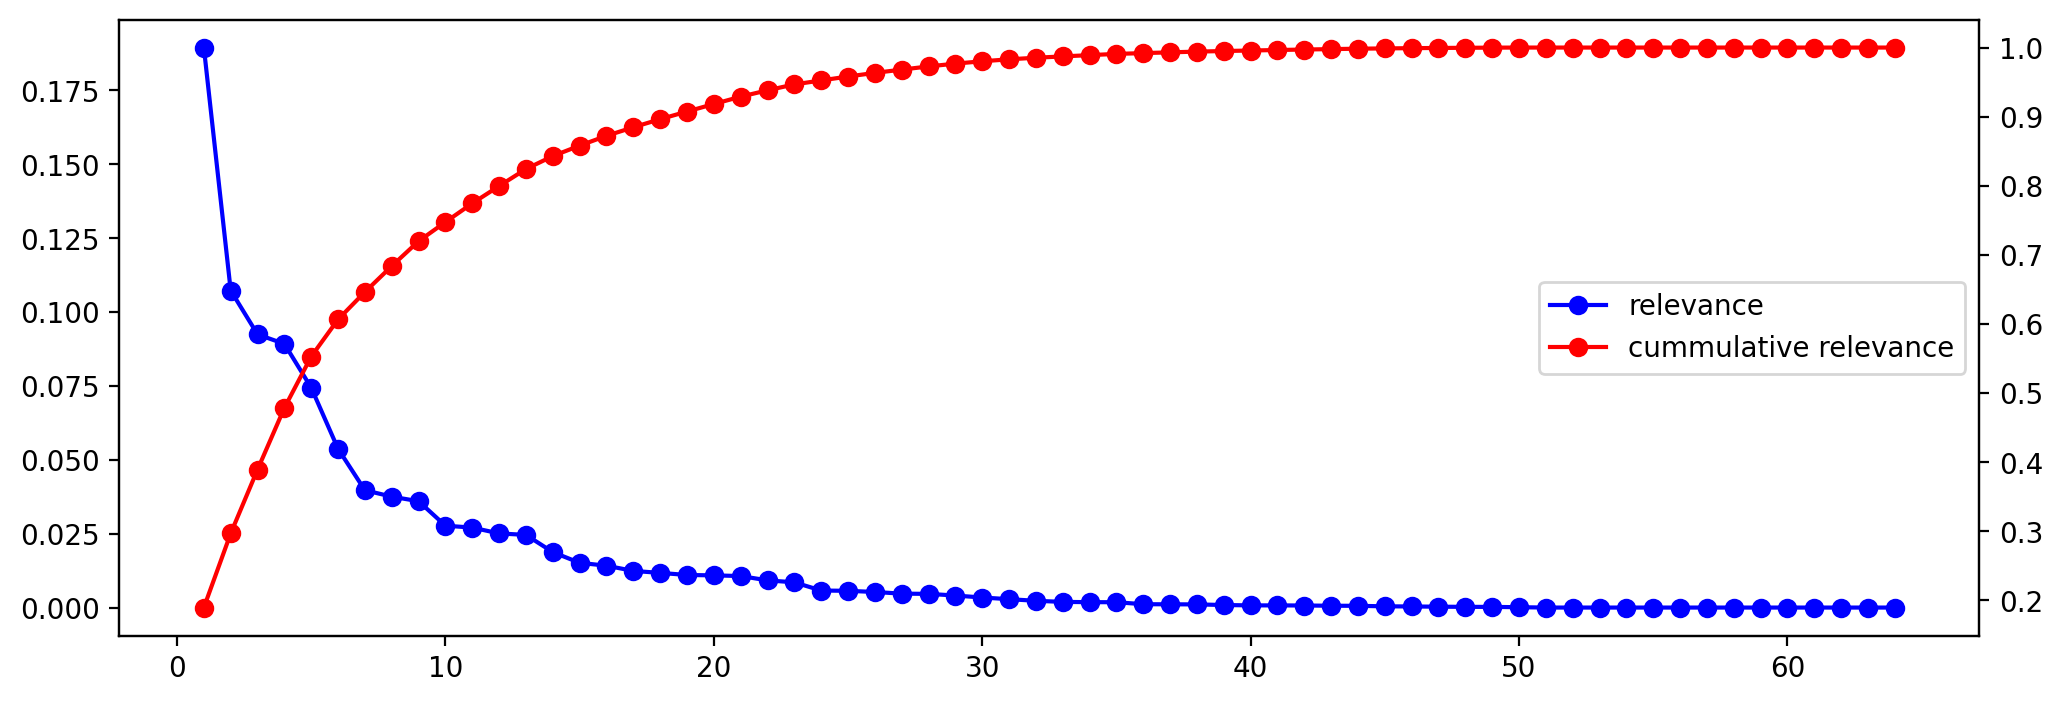

In [ ]:
ff,aa = plt.subplots(1,1,figsize=(12,4))
a1 = aa.plot([cc for cc in range(1,65)],
         feature_relevance_rf_56[sorted_indices_rf_56],
         marker='o',
         label='relevance',
        color = 'blue')
bb = aa.twinx()

b1 = bb.plot([cc for cc in range(1,65)],
         np.cumsum(feature_relevance_rf_56[sorted_indices_rf_56]),
         marker='o',
         label='cummulative relevance',
        color='red')

c = a1+b1
labs = [l.get_label() for l in c]
_=aa.legend(c, labs, loc='center right')

## 2.2 Analysis with Gaussian Processes

Repeat section 1.2 but with the new datasets.

In [ ]:
"""
Your code
"""
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the kernel
# Instead of a single lengthscale for all features, using an array of lengthscales, one for each feature
kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(Xtrain_binary.shape[1]), (1e-3, 1e10))

# Create and train the Gaussian Process classifier
gp_classifier = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=5, random_state=42)
gp_classifier.fit(Xtrain_binary, Ytrain_binary)

# Evaluate accuracy
accuracy = gp_classifier.score(Xtest_binary, Ytest_binary)
print("Gaussian Process Accuracy:", accuracy)

# Get lengthscales
# Since we're using an array of lengthscales, this should now work correctly
lengthscales_gp_56 = gp_classifier.kernel_.k2.get_params()['length_scale']
sorted_indices_gp_56 = np.argsort(lengthscales_gp_56)


Gaussian Process Accuracy: 0.9949238578680203


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:45

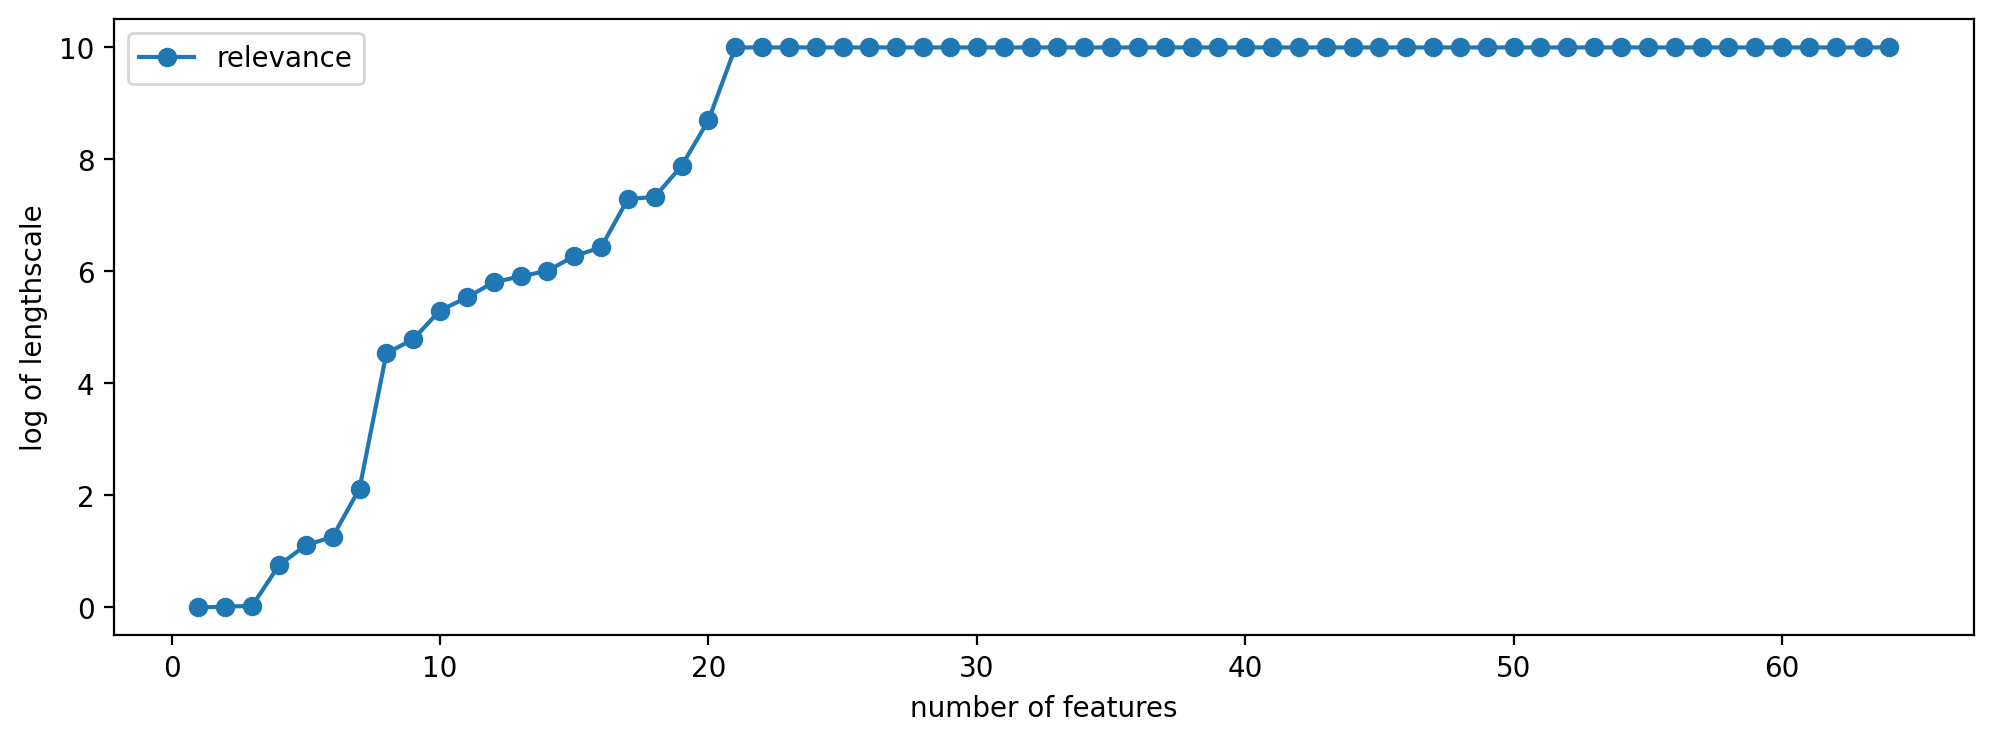

In [ ]:
ff,aa = plt.subplots(1,1,figsize=(12,4))
a1 = aa.plot([cc for cc in range(1,65)],
         np.log10(lengthscales_gp_56[sorted_indices_gp_56]),
         marker='o',
         label='relevance')
aa.set_ylabel('log of lengthscale')
aa.set_xlabel('number of features')
_= aa.legend()

## 2.3 Explanation of outcome

Repeat section 1.3 but with the new datasets.

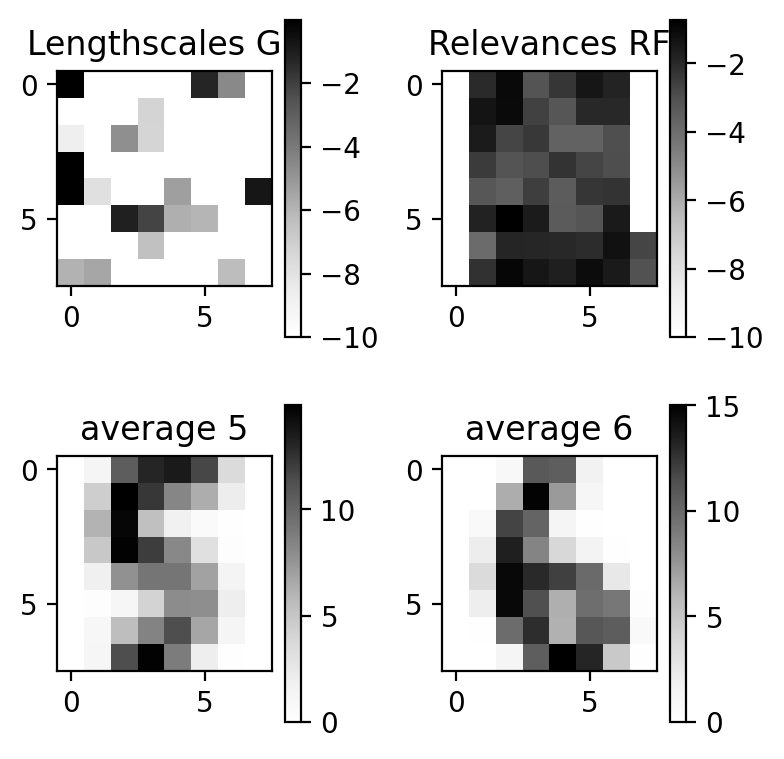

In [ ]:
ff,aa = plt.subplots(2,2, figsize=(4,4))
# The first row plots the relevance of each pixels according to GP (left) and to RF (right)
# The values are scaled between -10 (less relevant) and 0 (more relevant).
# With the color codes black means relevant and white non relevant

log_ls_gp = -np.log10(lengthscales_gp_56)

ax = aa[0][0]
cc = ax.imshow(log_ls_gp.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('Lengthscales GP')

log_fi_rf = -10*np.ones(64)
log_fi_rf[feature_relevance_rf_56>0] = np.log10(feature_relevance_rf_56[feature_relevance_rf_56>0])
ax = aa[0][1]
cc = ax.imshow(log_fi_rf.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('Relevances RF')

# The second row plots show the average observation of each class, in order to get insights about
# how the values of the pixels are distributed in each class. The intuition is that relevant pixels
# should be those that look different depending on the observation being a member of the positive
# or of the negative class.

ax = aa[1][0]
## compute the mean of the observations of in the training set of the positive class
##
## YOUR CODE
##
mean_positive_class = np.mean(Xtrain_binary[Ytrain_binary == cp], axis=0)
cc = ax.imshow(mean_positive_class.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('average {0:d}'.format(cp))

ax = aa[1][1]
## compute the mean of the observations of in the training set of the negative class
##
## YOUR CODE
##
mean_negative_class = np.mean(Xtrain_binary[Ytrain_binary == cn], axis=0)
cc = ax.imshow(mean_negative_class.reshape(8,8),cmap='Greys')
ff.colorbar(cc,ax=ax)
ax.set_title('average {0:d}'.format(cn))


ff.tight_layout()